# 人工データの作成

In [1]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs
from lightning.pytorch import seed_everything
from sklearn.decomposition import PCA

plt.style.use("ggplot")
seed_everything(8)

Seed set to 8


8

In [2]:
N_DATA = 5000  # データ数
N_CLUSTERS = 8  # クラスタ数
N_FEATURES = 10  # 特徴量数
RANDOM_STATE = 0  # 乱数シード
Y_SCALE = 1  # 目的変数の標準偏差
CLUSTER_STD = 1  # クラスタの標準偏差

# 人工データを生成
X, cluster_label = make_blobs(
    n_samples=N_DATA,
    centers=N_CLUSTERS,
    n_features=N_FEATURES,
    random_state=RANDOM_STATE,
    cluster_std=CLUSTER_STD,
)

# データの目的変数を N(cluster_label, Y_SCALE) に従うように生成
y = np.random.normal(cluster_label, Y_SCALE)

# # 各クラスタのデータ数が同じの為，適当にサンプリングしてばらつきを持たせる
# Xs = []
# cluster_labels = []
# ys = []
# for i in range(N_CLUSTERS):
#     idx = np.where(cluster_label == i)[0]
#     n_samples = np.random.randint(100, len(idx))  # クラスタごとにサンプリング数を変える
#     sample_idx = np.random.choice(idx, n_samples, replace=False)
#     Xs.append(X[sample_idx])
#     cluster_labels.append(cluster_label[sample_idx])
#     ys.append(y[sample_idx])

# X = np.concatenate(Xs)
# cluster_label = np.concatenate(cluster_labels)
# y = np.concatenate(ys)

## 生成したデータの分布を確認

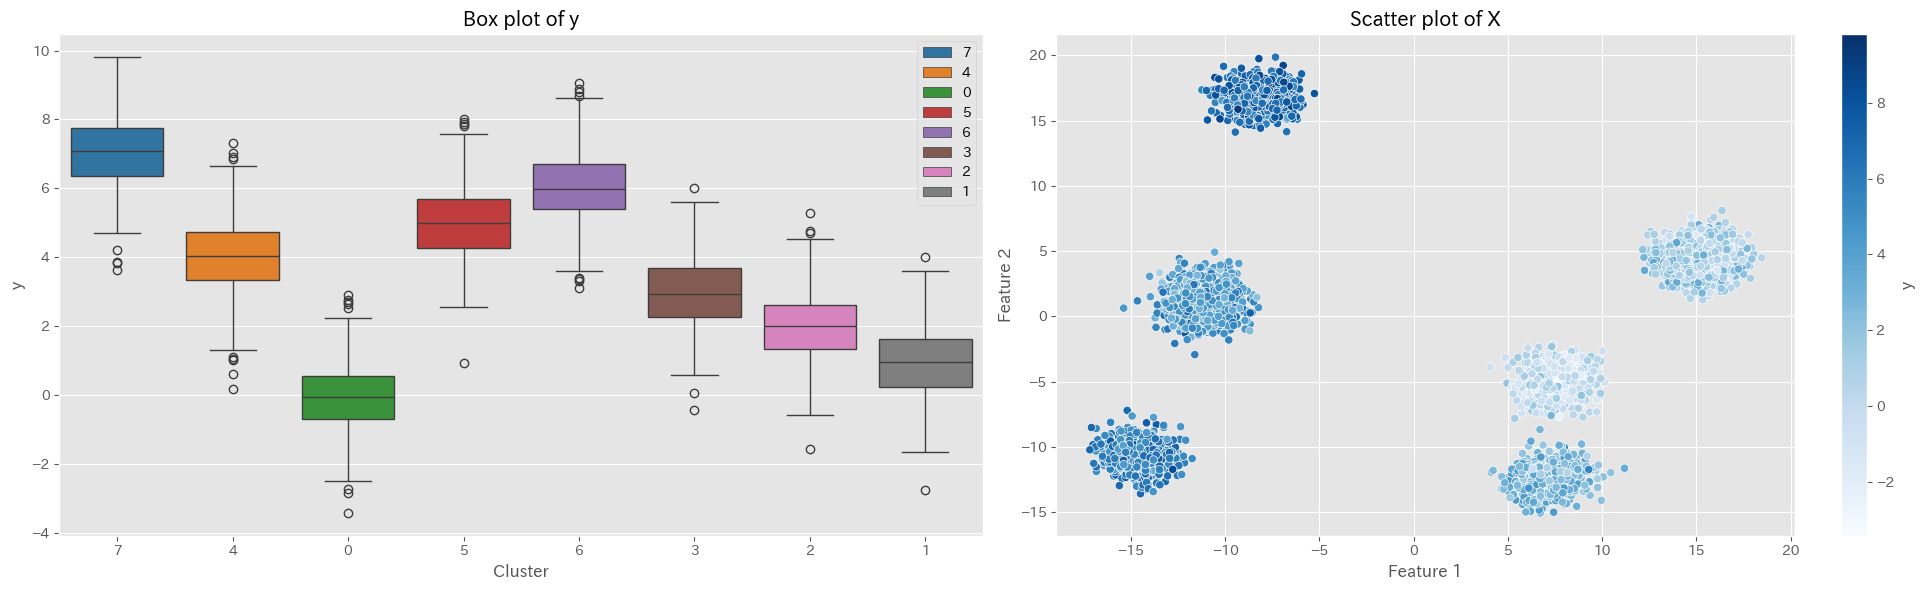

In [3]:
# 目的変数の分布
axes: list[plt.Axes]
fig, axes = plt.subplots(1, 2, figsize=(10 * 2, 6 * 1))
sns.boxplot(
    x=cluster_label.astype(str),
    y=y,
    ax=axes[0],
    hue=cluster_label.astype(str),
    palette="tab10",
    legend=True,
)
axes[0].set_title("Box plot of y")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("y")

# データの散布図
## 次元削減
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=axes[1], palette="Blues", legend=False)
axes[1].set_title("Scatter plot of X")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")
## colorbar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=y.min(), vmax=y.max()))
sm._A = []
cbar = fig.colorbar(sm, ax=axes[1])
cbar.set_label("y")

fig.tight_layout()

# 標本戦略の実装

## 基底クラス

インターフェースを統一するための基底クラスを作成

In [4]:
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray
from sklearn.cluster import KMeans


class BaseAllocation(metaclass=ABCMeta):
    def __init__(self, n_samples: int, H: int, random_state: int):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): 特徴量 (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        """クラスタリングを行う

        Args:
            X (NDArray): 特徴量 (N x M)

        Returns:
            NDArray: クラスタラベル (N, ), クラスタサイズ (H, )

        Note:
            N: データ数
            M: 特徴量数
            H: クラスタ数
        """
        kmeans = KMeans(n_clusters=self.H, random_state=self.random_state)
        cluster_label = kmeans.fit_predict(X)
        _, cluster_size = np.unique(cluster_label, return_counts=True)
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size.copy()

## Random Allocation

In [5]:
from numpy.typing import NDArray


class RandomAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        cluster_label = np.zeros(X.shape[0])
        cluster_size = np.array([len(cluster_label)])
        return cluster_label, cluster_size

## Equal Allocation

In [6]:
class EqualAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタから均等に標本を選ぶ"""
        n = np.full(self.H, self.n_samples // self.H)

        # nがクラスタサイズより大きい場合はクラスタサイズに合わせる
        n = np.minimum(n, self.N)
        return n

## Propotional Allocation

In [7]:
class PropotionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nがn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        return n

## 最適標本配分
Binary SearchもしくSimple Greedy [1]で各クラスタのサンプル数を決定

[1]: Ulf Friedrich, Ralf Münnich, Sven de Vries, Matthias Wagner, 2015. Fast
   integer-valued algorithms for optimal allocations under constraints in stratified
   sampling. Computational Statistics and Data Analysis 92(2015) 1-12.

In [8]:
from typing import Literal, Optional

from numpy.typing import NDArray


class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,
        M: Optional[NDArray] = None,
        method: Literal["binary", "greedy"] = "greedy",
        random_state: int = 0,
    ):
        super().__init__(n_samples, H, random_state)
        self.m = m  # 各クラスタの最小標本数 (H, )
        self.M = M  # 各クラスタの最大標本数 (H, ), (指定しない場合はクラスタサイズ)
        self.method = method

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # クラスタ毎の目的変数のvariance (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )

        if self.method == "binary":
            n = self._binary_search(d=d)
        elif self.method == "greedy":
            n = self._simple_greedy(n=self.m.copy(), d=d)
        else:
            raise ValueError(f"Invalid method: {self.method}")

        # 制約チェック
        self._check_constraints(n)

        return n

    def _binary_search(self, d: NDArray) -> NDArray:
        I = np.arange(self.H)  # noqa (H, )
        n = self.m.copy()  # 各クラスタの標本数 (H, )
        u_old = self.m.copy()  # (H, )
        m = self.m.copy()  # 各クラスタの最小標本数 (H, )
        M = (
            self.M.copy() if self.M is not None else self.N.copy()
        )  # クラスタサイズ (H, ), (指定しない場合はクラスタサイズ)

        while n.sum() != self.n_samples:
            u = u_old.copy()
            delta = np.zeros(self.H)
            u[I] = np.floor((M + m) / 2)[I]
            delta[I] = (d / u - d / (u - 1))[I]

            if not np.all(u == u_old):
                s = np.median(delta[I])
            else:
                if (M - m + 1)[I].max() == 2:
                    n = self._simple_greedy(n, d)
                    return n

                h_star = np.argmax((M - m + 1)[I])
                h_star = I[h_star]
                s = delta[h_star]

            n[I] = np.floor(0.5 + np.sqrt(0.25 - d * (s ** (-1))))[I]
            n[I] = np.maximum(n, m)[I]  # if n_h < m_h, n_h <- m_h
            n[I] = np.minimum(n, M)[I]  # if n_h > M_h, n_h <- M_h

            if n.sum() < self.n_samples:
                m = n.copy()
            else:
                M = n.copy()

            # m == MのindexをIから削除
            I_ = I.tolist()
            I_ = [i for i in I_ if m[i] != M[i]]
            I = np.array(I_)  # noqa
            u_old = u.copy()

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert n.sum() <= self.n_samples, f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(n <= self.M), "Maximum sample size constraint is not satisfied"

# 比較実験

In [9]:
import numpy as np
from numpy.typing import NDArray


def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat

In [10]:
N_SAMPLES = 100  # 標本数
H = 10  # クラスタ数
N_TRIALS = 100  # 試行回数
m_VALUE = 2  # 各クラスタの最小標本数

# 戦略を定義
policies: list[BaseAllocation] = [
    RandomAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    EqualAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    PropotionalAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
    ),
]

# それぞれの戦略で各クラスタの標本数を求解
allocations: list[dict] = []
for policy in policies:
    cluster_label, _ = policy.clustering(X)
    n = policy.solve(X, y)
    allocations.append(
        {
            "policy": policy.__class__.__name__,
            "n": n,
            "cluster_label": cluster_label,
        }
    )

# 各戦略の標本数に基づいて目的変数の平均を推定
y_hats = []
for random_state in range(N_TRIALS):
    for allocation in allocations:
        y_hat = estimate_y_mean(allocation["n"], allocation["cluster_label"], y)
        y_hats.append(
            {
                "policy": allocation["policy"],
                "y_hat": y_hat,
                "random_state": random_state,
            }
        )

(0.0, 100.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


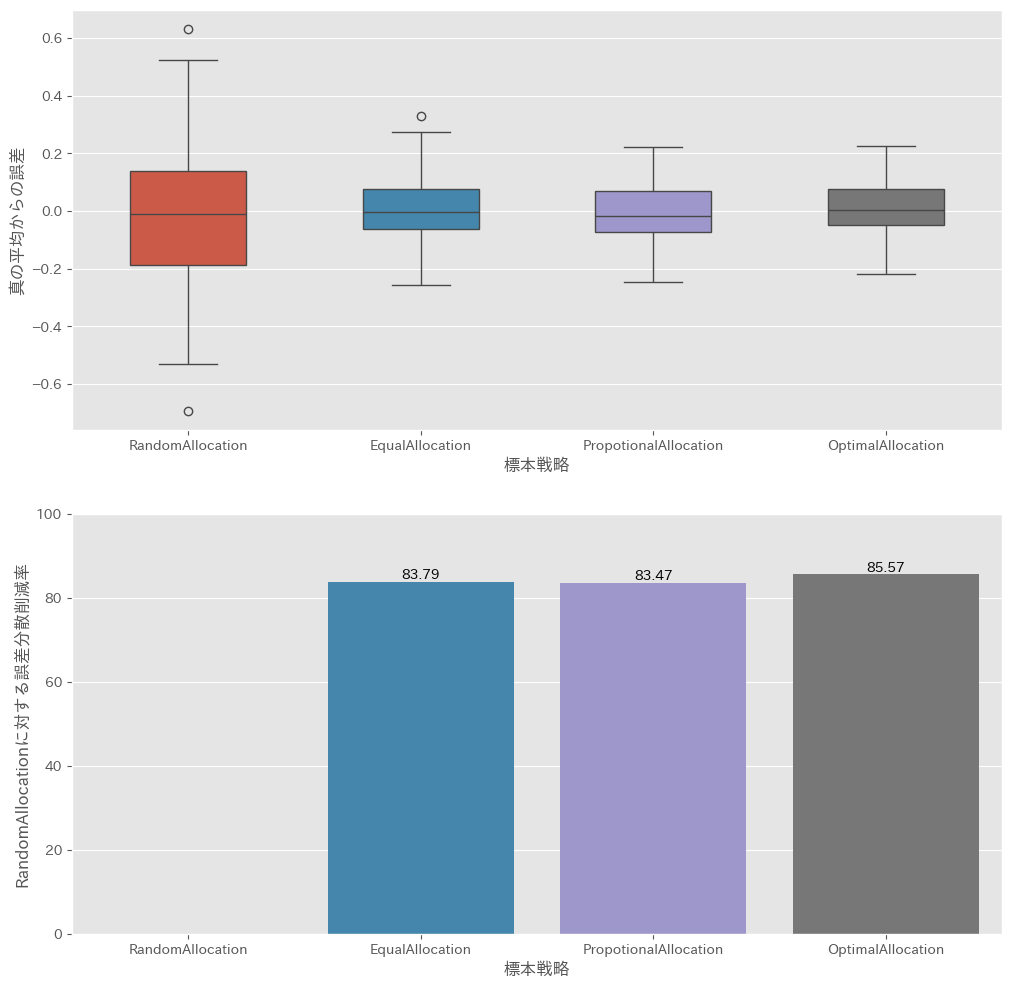

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

axes: list[plt.Axes]
fig, axes = plt.subplots(2, 1, figsize=(12, 6 * 2))

# 箱ひげ図で誤差の分布を比較
y_hat_df = pd.DataFrame(y_hats)
y_hat_df["error"] = y_hat_df["y_hat"] - y.mean()  # 真の平均からの誤差
sns.boxplot(data=y_hat_df, y="error", x="policy", hue="policy", ax=axes[0], linewidth=1, width=0.5)
axes[0].set_ylabel("真の平均からの誤差")
axes[0].set_xlabel("標本戦略")

# 棒グラフでRandomAllocationに対する誤差分散削減率を比較
random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"]["error"].var()
non_random_allocation_std = (
    y_hat_df[y_hat_df["policy"] != "RandomAllocation"].groupby("policy")["error"].var()
)
reduction_rate = (1 - non_random_allocation_std / random_allocation_std) * 100  # 削減率 (%)
## policyの順番を調整
reduction_rate = reduction_rate.reindex([policy.__class__.__name__ for policy in policies])
sns.barplot(x=reduction_rate.index, y=reduction_rate.values, ax=axes[1], hue=reduction_rate.index)
# 棒グラフの上に値を表示
for i, v in enumerate(reduction_rate.values):
    axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_ylabel("RandomAllocationに対する誤差分散削減率")
axes[1].set_xlabel("標本戦略")
axes[1].set_ylim(0, 100)